In [2066]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../rfsoc_lib')
# from rfsoc_calibration import RfsocCalibration
from rfsoc_pulses import RfsocPulses
from rfsoc_arb_pulses import RfsocArbPulses

import pickle
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2067]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [2279]:
# ------ INPUT -------
# Frequency: Var
# Phase: Var
# Amplitude: Var
input_seq = ([10, 0.8, 0.2, 90], [10, 0], [50, 1.0, 0.1, 0])
input_obj = RfsocArbPulses(soccfg, input_seq, outsel='input')

# ------ PRODUCT ------
# Frequency: FIXED
# Phase: Var
# Amplitude: Var
product_seq = ([20, 1.0, 0.1, 0], [20, 1.0, 0.1, 180], [10,0], [50, 1.0, 0.1, 0])
product_obj = RfsocArbPulses(soccfg, product_seq, outsel='product')

dac_seq = [input_obj, (10, 0), (20, 1.0, 0.1, 0), product_obj]
sequences = {'DAC_A': dac_seq, 'DIG_0': [(10, 1)]}

delays = {"DAC_A": 0, "DAC_B": 0, "DIG_0": 38}
gains = {'DAC_A': 10000}

pulses = RfsocPulses(sequences,
                     delays=delays,
                     gains=gains,
                     print_params=True
                     )

WARNING! Not all sequences are of the same duration: [0.2, 0.01]
----- DAC A -----
ch_type: DAC
ch_index: 1
delay: 0
gain: 10000
lengths: [0.07, 0.02, 0.1]
times: [0.0, 0.08, 0.1]
amps: ['arb', 1.0, 'arb']
freqs: ['input', 100.0, 100.0]
phases: ['arb', 0.0, 'arb']
styles: ['arb', 'const', 'arb']
outsels: ['input', None, 'product']
num_pulses: 3
duration: 0.2
----- DIG 0 ------
ch_type: DIG
ch_index: 0
delay: 38
lengths: [0.01]
times: [0.0]
num_pulses: 1
duration: 0.01
----- End time: 0.2 -----


In [2287]:
prog = QickProgram(soccfg)
pulses.generate_asm(prog, reps=1)
pulses.config_internal_start(soc, prog)
soc.tproc.start() # Run program
print(prog)


// Program

        synci 200;
        regwi 0, $14, 0;
LOOP_I: regwi 1, $22, 0;                        //freq = 0
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 10000;                    //gain = 10000
        regwi 1, $24, 0;                        //addr = 0
        regwi 1, $26, 655404;                   //phrst| stdysel | mode | | outsel = 0b01010 | length = 44 
        regwi 1, $27, 0;                        //t = 0
        set 1, 1, $22, $23, $24, $25, $26, $27; //ch = 1, pulse @t = $27
        regwi 1, $22, 43690667;                 //freq = 43690667
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 5000;                     //gain = 5000
        regwi 1, $26, 589836;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 12 
        regwi 1, $27, 33;                       //t = 33
        set 1, 1, $22, $23, $0, $25, $26, $27;  //ch = 1, pulse @t = $27
        regwi 1, $22, 43690667;        

In [1165]:
soc.reset_gens()

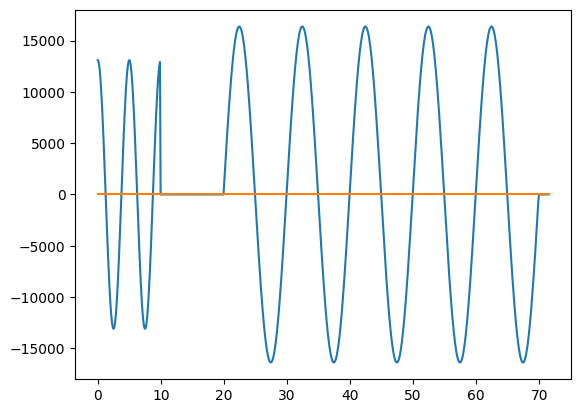

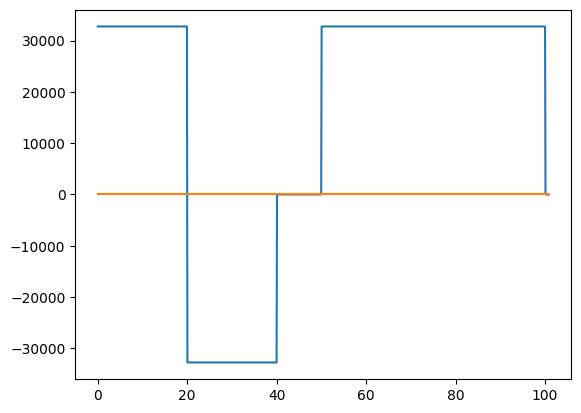

In [2268]:
x = np.arange(0, round(len(input_obj.idata) * 1e3 / 9830.4, 2), 1e3 / 9830.4)
plt.plot(x, -input_obj.idata)
plt.plot(x, input_obj.qdata)
plt.show()

x = np.arange(0, round(len(product_obj.idata) * 1e3 / 9830.4, 2), 1e3 / 9830.4)
plt.plot(x, product_obj.idata)
plt.plot(x, product_obj.qdata)
plt.show()